# Lab 02 : CIFAR multi-layer -- exercise

In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    # find automatically the path of the folder containing "file_name" :
    file_name = 'cifar_multilayer_exercise.ipynb'
    import subprocess
    path_to_file = subprocess.check_output('find . -type f -name ' + str(file_name), shell=True).decode("utf-8")
    path_to_file = path_to_file.replace(file_name,"").replace('\n',"")
    # if previous search failed or too long, comment the previous line and simply write down manually the path below :
    #path_to_file = '/content/gdrive/My Drive/AI6103_2020_codes/codes/labs_lecture06/lab02_cifar_multilayer'
    print(path_to_file)
    # change current path to the folder containing "file_name"
    os.chdir(path_to_file)
    !pwd
    

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from random import randint
import utils
import time

### With or without GPU?

It is recommended to run this code on GPU:<br> 
* Time for 1 epoch on CPU : 5 sec<br> 
* Time for 1 epoch on GPU : 0.6 sec w/ GeForce GTX 1080 Ti<br>

In [3]:
device= torch.device("cuda")
# device= torch.device("cpu")
print(device)

cuda


### Download the CIFAR dataset 

In [4]:
from utils import check_cifar_dataset_exists
data_path=check_cifar_dataset_exists()

train_data=torch.load(data_path+'cifar/train_data.pt')
train_label=torch.load(data_path+'cifar/train_label.pt')
test_data=torch.load(data_path+'cifar/test_data.pt')
test_label=torch.load(data_path+'cifar/test_label.pt')

print(train_data.size())

torch.Size([50000, 3, 32, 32])


### Make a Three layer net class. 

In [5]:
class three_layer_net(nn.Module):

    def __init__(self, input_size, hidden_size1, hidden_size2,  output_size):
        super(three_layer_net , self).__init__()
        
        self.layer1 = nn.Linear(input_size, hidden_size1) # COMPLETE HERE
        self.layer2 = nn.Linear(hidden_size1, hidden_size2) # COMPLETE HERE
        self.layer3 = nn.Linear(hidden_size2, output_size)# COMPLETE HERE
        
    def forward(self, x):
        
        y       = self.layer1(x) # COMPLETE HERE
        y_hat   = F.relu(y) # COMPLETE HERE
        z       = self.layer2(y_hat) # COMPLETE HERE
        z_hat   = F.relu(z) # COMPLETE HERE
        scores  = self.layer3(z_hat) # COMPLETE HERE
        
        return scores

### Build the net with the following size:
* input size = 3,072
* hidden size 1 = 500
* hidden size 2 = 500
* output size = 10
### How many parameters in total? (the one layer net had 30,000 parameters)

In [6]:
net=three_layer_net(3072,500,500,10)
print(net)
utils.display_num_param(net)

three_layer_net(
  (layer1): Linear(in_features=3072, out_features=500, bias=True)
  (layer2): Linear(in_features=500, out_features=500, bias=True)
  (layer3): Linear(in_features=500, out_features=10, bias=True)
)
There are 1792010 (1.79 million) parameters in this neural network


### Send the weights of the networks to the GPU

In [8]:
net= net.to(device) # COMPLETE HERE

### Choose the criterion and optimizer. Also choose:
* batch size =200
* learning rate =0.01


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.SGD( net.parameters() , lr=0.01 )
bs= 200 # COMPLETE HERE

### Function to evaluate the network on the test set

In [10]:
def eval_on_test_set():

    running_error=0
    num_batches=0


    for i in range(0,10000,bs):

        # extract the minibatch
        minibatch_data =  test_data[i:i+bs]
        minibatch_label= test_label[i:i+bs]

        # send them to the gpu
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)

        # reshape the minibatch
        inputs = minibatch_data.view(bs,3072)

        # feed it to the network
        scores=net( inputs ) 

        # compute the error made on this batch
        error = utils.get_error( scores , minibatch_label)

        # add it to the running error
        running_error += error.item()

        num_batches+=1


    # compute error rate on the full test set
    total_error = running_error/num_batches

    print( 'error rate on test set =', total_error*100 ,'percent')

### Do 160 passes through the training set.

In [11]:
start=time.time()

for epoch in range(160):
    
    running_loss=0
    running_error=0
    num_batches=0
    
    shuffled_indices=torch.randperm(50000)
 
    for count in range(0,50000,bs):
    
        # Set the gradients to zeros
        optimizer.zero_grad()
        
        # create a minibatch       
        indices= shuffled_indices[count:count+bs]         # COMPLETE HERE
        minibatch_data = train_data[indices] # COMPLETE HERE
        minibatch_label= train_label[indices] # COMPLETE HERE
        
        # send the minibatch to the gpu
        minibatch_data= minibatch_data.to(device) # COMPLETE HERE
        minibatch_label= minibatch_label.to(device) # COMPLETE HERE
        
        # reshape the minibatch
        inputs = minibatch_data.view(bs, 3072) # COMPLETE HERE

        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net 
        scores= net(inputs) # COMPLETE HERE 

        # Compute the average of the losses of the data points in the minibatch
        loss = criterion(scores, minibatch_label) # COMPLETE HERE 
        
        # backward pass to compute dL/dU, dL/dV and dL/dW   
        loss.backward()

        # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
        optimizer.step()
        
        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()
        
        # compute the error made on this batch and add it to the running error       
        error = utils.get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1
    
    
    # compute stats for the full training set
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = time.time()-start
    
    if epoch%20 == 0:
        print('epoch=',epoch, '\t time=', elapsed, '\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
        eval_on_test_set() 
        print(' ')
    
    
        
        

epoch= 0 	 time= 1.3016178607940674 	 loss= 2.242588554382324 	 error= 80.0740005016327 percent
error rate on test set = 76.25000059604645 percent
 
epoch= 20 	 time= 17.78516721725464 	 loss= 1.5892063298225403 	 error= 56.00200133323669 percent
error rate on test set = 55.69000113010406 percent
 
epoch= 40 	 time= 35.08412265777588 	 loss= 1.4140566248893738 	 error= 49.72800054550171 percent
error rate on test set = 52.260000586509705 percent
 
epoch= 60 	 time= 51.384222984313965 	 loss= 1.2863248076438905 	 error= 45.20600092411041 percent
error rate on test set = 49.05000042915344 percent
 
epoch= 80 	 time= 68.44456601142883 	 loss= 1.18789786195755 	 error= 41.76000111103058 percent
error rate on test set = 47.010000586509705 percent
 
epoch= 100 	 time= 85.76867461204529 	 loss= 1.0981577899456023 	 error= 38.50000145435333 percent
error rate on test set = 47.62000072002411 percent
 
epoch= 120 	 time= 102.50048637390137 	 loss= 1.0215936295986177 	 error= 35.78800139427185 pe

### Choose image at random from the test set and see how good/bad are the predictions

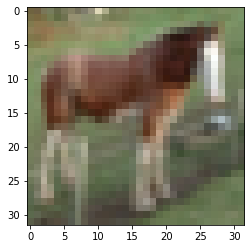

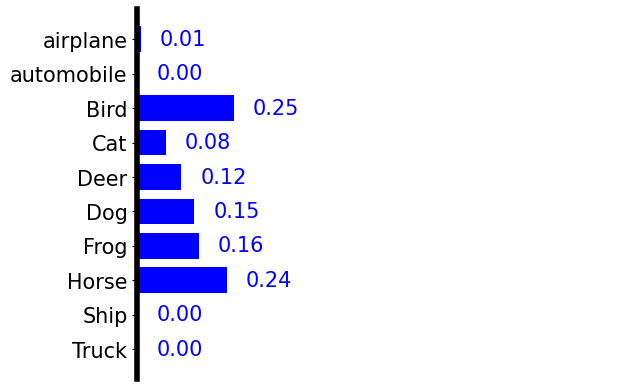

In [12]:
# choose a picture at random
idx=randint(0, 10000-1)
im=test_data[idx]

# diplay the picture
utils.show(im)

# feed it to the net and display the confidence scores
scores =  net( im.view(1,3072).to(device)) 
probs= F.softmax(scores, dim=1)
utils.show_prob_cifar(probs.cpu())